In [2]:
import os, sys
import shutil, glob, time
from path import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import cv2
from PIL import Image, ImageDraw
from skimage.metrics import structural_similarity

%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

## Subroutines used for processing

In [3]:
# Function to list files in the directory
# def list_contents(directory,casename,filetype): 
def list_contents(directory,filetype): 
    file_list = []            
    for cnt,value in enumerate(os.listdir(directory)):
#         if (filetype in value and casename in value):
        if (filetype in value):
            file_list.append(value)           
    list_dir = [f.lower() for f in file_list]   # Convert to lower case
    
    return sorted(list_dir)


# Calculate number of frames
def get_num_frames(filename):
    vidObj = cv2.VideoCapture(filename)
    # Checks whether frames were extracted
    success = 1
    num_frames = 1
    while success:  
        success, raw_image = vidObj.read()
        num_frames += 1          
    return num_frames
    
    
# Gets information about a video file
def with_ffprobe(filename):
    import subprocess, json

    result = subprocess.check_output(
            f'ffprobe -v quiet -show_streams -select_streams v:0 -of json "{filename}"',
            shell=True).decode()
    fields = json.loads(result)['streams'][0]
    duration = fields['duration']
    fps      = eval(fields['r_frame_rate'])
    frames   = fields['nb_frames']
    return float(duration),int(frames)


def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img


def decrease_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = value
    v[v < lim] = 0
    v[v >= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img


def increase_contrast(img):

    #-----Reading the image-----------------------------------------------------
#     img = frame
    # cv2.imshow("img",img) 

    #-----Converting image to LAB Color model----------------------------------- 
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    # cv2.imshow("lab",lab)

    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)
    # cv2.imshow('l_channel', l)
    # cv2.imshow('a_channel', a)
    # cv2.imshow('b_channel', b)

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=-1, tileGridSize=(8,8))
    cl = clahe.apply(l)
    # cv2.imshow('CLAHE output', cl)

    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl,a,b))
    # cv2.imshow('limg', limg)

    #-----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    # cv2.imshow('final', final)
    
    return final


# Function to show image
def showimage(image):
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    

# Function to show image w/ mask
def select_mask(image,ip):

    # Sub-function to get user-based coordinates
    def get_coord(event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN:
            cv2.circle(image,(x,y),5,(0,0,225),-1) # create a circle around selected points
            bound_list.append([x, y])
            print('Selected coordinates',x,y)
            
    bound_list = []
    cv2.namedWindow('Mask')
#     cv2.namedWindow('Mask', cv2.WINDOW_NORMAL)
#     cv2.resizeWindow('Mask', (600,600) )
    cv2.setMouseCallback('Mask',get_coord)
    while(1):
        cv2.imshow('Mask',image)
        if (cv2.waitKey(1) & 0xFF == ord('q')):
            break
    cv2.destroyAllWindows()
    for i in range (1,5):
        cv2.waitKey(1)
    
    return bound_list


# Function to crop image to any shape
def process_cropping(image_in,bound_list):
        
    # Create dummy image from image_in for compatibility with "PIL" module
    dummy = Image.fromarray(image_in)
    
    # Create mask as per "bound_list"
    xy = [tuple(x) for x in bound_list]
    mask = Image.new("L", dummy.size, 0)
    draw = ImageDraw.Draw(mask)
    draw.polygon(xy, fill=255, outline=None)
    
    # Crop image per mask
    masked_image = cv2.bitwise_and(image_in, image_in, mask=np.array(mask))

    # Calculat area in terms of no. of pixels inside the mask
    a = np.asarray(mask)
    b = np.where(a==255)
    masked_region_area = len(b[0])
    
    return masked_image, masked_region_area


def preprocess_data(ip):
    
    # Go to main processing directory
    filename = ip['file_proc']
    os.chdir(ip['proc_dir'])    
    dirname = filename[0:-4]
    ip['temp_dir'] = ip['proc_dir'] / dirname

    # Create directory if it doesn't exist
    if os.path.isdir(dirname): pass
    else: os.mkdir(dirname)
    shutil.copy(ip['proc_dir']+'/'+filename,ip['temp_dir']) # Copy file to temp directory
    os.chdir(ip['temp_dir'])

    # Get time array & num_frames from movie
    [duration,num_frames] = with_ffprobe(filename) 
    ip['time_array'] = np.linspace(0,duration,num=num_frames)
    if (ip['delete_last_frame'] == 'y'): ip['num_frames'] = num_frames - 1
    else: ip['num_frames'] = num_frames
    #num_frames = get_num_frames(filename)

    # Extract mask
    ip['bound_list'] = []
    if (ip['create_mask'] == 'y'):
        vidObj = cv2.VideoCapture(filename)
        success = 1 # checks whether frames were extracted
        if (ip['create_mask'] == 'y'):
            # Make selection for required number of masks
            for i in range(ip['num_frames']): 
                success, raw_image = vidObj.read()
                if (i == ip['mask_frame'] - 1):
                    # Rotate movie if needed
                    if (ip['rotate_movie'] == 'y'):
                        raw_image = cv2.rotate(raw_image, cv2.ROTATE_90_CLOCKWISE)
                    for k in range(ip['num_masks']):
                        if (ip['mask_manual']):
                            print('Selecting mask no = ', k, 'from frame no = ', i)
                            bound_list = select_mask(raw_image,ip)
                            ip['bound_list'].append(bound_list)
                        if (not(ip['mask_manual'])):
                            ip['bound_list'] = ip['coordinate_list'] 
                        # Save each mask
                        [masked_image,masked_region_area] = process_cropping(raw_image,ip['bound_list'][k])
                        plt.figure(k)
                        showimage(masked_image)
                        plt.savefig('Mask'+str(k)+'.jpg',dpi=300)
                    plt.close('all')
                    print('Mask extraction complete')
                    break    
    
    return ip


# Function to write out data in excel file
def write_out_data(data_out,ip):
    
    # Go to specific directory
    os.chdir(ip['temp_dir'])
    
    writer = pd.ExcelWriter('Output_Edge.xlsx')
    data_out.to_excel(writer,sheet_name='Data')
    writer.save()
    
    # Back to main directory
    os.chdir(ip['proc_dir'])
    
    return 


# Function to create plots
def create_plots(data_out_edge,ip):
    
    # Go to specific directory
    os.chdir(ip['temp_dir'])
    
    # Droplet area
    plt.figure()
    plt.rcParams["font.family"] = "Times New Roman" # Arial
    for k in range(ip['num_masks']):
        plt.plot(data_out_edge['Time'],data_out_edge['Droplet_area'+str(k)],label='Mask'+str(k))
    plt.xlabel('Time [sec]')
    plt.ylabel('Droplet area [$cm^2$]')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('Droplet_Area_Edge.jpg',dpi=300)

    # Area ratio
    plt.figure()
    plt.rcParams["font.family"] = "Times New Roman" # Arial
    for k in range(ip['num_masks']):
        plt.plot(data_out_edge['Time'],100*data_out_edge['Area_ratio'+str(k)],label='Mask'+str(k))
    plt.xlabel('Time [sec]')
    plt.ylabel('Area ratio [%]')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('Area_Ratio_Edge.jpg',dpi=300)

    # Obscuration normalized
    plt.figure()
    plt.rcParams["font.family"] = "Times New Roman" # Arial
    for k in range(ip['num_masks']):
        data_out_edge['ObscurationNorm'+str(k)] = 100*(np.asarray(data_out_edge['Droplet_area'+str(k)])/data_out_edge['Droplet_area'+str(k)][0])
        data_out_edge['Energy'] = ip['current'] * ip['voltage'] *np.asarray(data_out_edge['Time'])
        plt.plot(data_out_edge['Time'],data_out_edge['ObscurationNorm'+str(k)],label='Mask'+str(k))
    plt.xlabel('Time [sec]')
    plt.ylabel('Obscuration [%]')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('Obscuration_Normalized_Edge.jpg',dpi=300)

    # Obscuration absolute ==== SAME AS AREA RATIO ===> can use either to plot
    plt.figure()
    plt.rcParams["font.family"] = "Times New Roman" # Arial
    for k in range(ip['num_masks']):
        data_out_edge['ObscurationAbs'+str(k)] = 100*(np.asarray(data_out_edge['Droplet_area'+str(k)])/data_out_edge['Mask_area'+str(k)][0])
        plt.plot(data_out_edge['Time'],data_out_edge['ObscurationAbs'+str(k)],label='Mask'+str(k))
    plt.xlabel('Time [sec]')
    plt.ylabel('Obscuration [%]')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('Obscuration_Absolute_Edge.jpg',dpi=300)

    # Cleaning effectiveness --- normalized like obucuration 
    plt.figure()
    plt.rcParams["font.family"] = "Times New Roman" # Arial
    for k in range(ip['num_masks']):
        data_out_edge['CleaningEffNorm'+str(k)] = 100 - 100*(np.asarray(data_out_edge['Droplet_area'+str(k)])/data_out_edge['Droplet_area'+str(k)][0])
        plt.plot(data_out_edge['Time'],data_out_edge['CleaningEffNorm'+str(k)],label='Mask'+str(k))
    plt.xlabel('Time [sec]')
    plt.ylabel('Cleaning effectiveness [%]')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('CleaningEff_Normalized_Edge.jpg',dpi=300)
    
    # Back to main directory
    os.chdir(ip['proc_dir'])
    
    return data_out_edge
                                                      

## Contrast edge detection

In [4]:
def edge_detection(ip):

    # Starting time
    start_time = time.time()
    print('Using edge detection algorithm')

    # Initialize data arrays for each mask
    mask_area = {}
    droplet_area = {}
    area_ratio = {}
    img_array = {}
    for k in range(ip['num_masks']):
        mask_area[str(k)] = []
        droplet_area[str(k)] = []
        area_ratio[str(k)] = []
        img_array[str(k)] = []
    
    # Loop over each frame
    cnt1 = 1
    vidObj = cv2.VideoCapture(ip['file_proc'])
    for i in range(ip['num_frames']): # actual calculation loop
        
        # Read file
        success, raw_image = vidObj.read()
        
        # Rotate movie if needed
        if (ip['rotate_movie'] == 'y'):
            raw_image = cv2.rotate(raw_image, cv2.ROTATE_90_CLOCKWISE)
            
        # Crop file using base mask only and find corresponding image
        if (ip['create_mask'] == 'y'):
            [crop_image, dummy0] = process_cropping(raw_image,ip['bound_list'][0])
        else:
            crop_image = raw_image
            dummy0 = raw_image.shape[0]*raw_image.shape[1]
        mask_area['0'].append(dummy0)
#         crop_image = increase_contrast(crop_image)
            
        # Convert to greyscale & threshold using base mask only
        grey_image = cv2.cvtColor(crop_image, cv2.COLOR_BGR2GRAY)
#         thresh, grey_image_th_otsu = cv2.threshold(grey_image, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        thresh, grey_image_th_otsu = cv2.threshold(grey_image, 127, 255, cv2.THRESH_BINARY)
        
#         # Save base binarized mask image
#         if (i == 0):
#             plt.figure(i)
#             plt.imshow(grey_image_th_otsu,cmap='gray')
#             plt.savefig(str(k)+'.jpg',dpi=300)
        
        # Get cropped & binarized base image
        img_array['0'].append(cv2.cvtColor(grey_image_th_otsu,cv2.COLOR_GRAY2RGB))

        # Get droplet area for base mask
        dummy1 = cv2.countNonZero(grey_image_th_otsu)
        droplet_area['0'].append(dummy1)
        
        # Get area ratio for base mask
        dummy2 = dummy1/dummy0
        area_ratio['0'].append(dummy2)
        
        # Calculate pixel to length ratio
        ip['pixel_length_ratio_x'] = 1 # grey_image_th_otsu.shape[0]/ip['mask_length_x']
        ip['pixel_length_ratio_y'] = 1 # grey_image_th_otsu.shape[1]/ip['mask_length_y']
        
        # Loop over each mask for actual droplet stat calculation
        for k in range(ip['num_masks']):
            if (k >= 1): # since base mask is already completed
                [crop_grey_image, dummy0] = process_cropping(grey_image_th_otsu,ip['bound_list'][k])
                dummy1 = cv2.countNonZero(crop_grey_image)
                dummy2 = dummy1/dummy0
                img_array[str(k)].append(cv2.cvtColor(crop_grey_image,cv2.COLOR_GRAY2RGB))
                mask_area[str(k)].append(dummy0)
                droplet_area[str(k)].append(dummy1)
                area_ratio[str(k)].append(dummy2)
#                 # Save additional masked binarized images
#                 if (i == 0):
#                     plt.figure(k)
#                     plt.imshow(crop_grey_image,cmap='gray')
#                     plt.savefig(str(k)+'.jpg',dpi=300)        
        cnt1 += 1
        plt.close('all')

    # Return data
    data_out = pd.DataFrame()
    data_out['Time'] = ip['time_array']
    for k in range(ip['num_masks']):
        data_out['Mask_area'+str(k)] = mask_area[str(k)]
        data_out['Droplet_area'+str(k)] = droplet_area[str(k)]
        data_out['Area_ratio'+str(k)] = area_ratio[str(k)]
        
    # Save the cleaning movie
    if (ip['create_cleaning_movie'] == 'y') :
        for k in range(ip['num_masks']):
            height, width, layers = img_array[str(k)][0].shape
            size = (width,height)
            out = cv2.VideoWriter('Cleaning_Edge'+str(k)+'.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 30, size) 
            for i in range(len(img_array[str(k)])):
                out.write(img_array[str(k)][i])
            out.release()

    # Delete file from temp directory and close figures
    try:
        os.remove(ip['file_proc']) 
    except:
        pass
    plt.close('all')
    os.chdir(ip['proc_dir'])    

    # Total time taken
    end_time = time.time()
    print("Runtime = %6.2f secs" %(end_time - start_time))
    
    return data_out

## Basic inputs

In [5]:
# Inputs for running 
ip = {}
ip['create_mask'] = 'y' # don't use mask at all
ip['mask_manual'] = 0 # methodology for selecting the mask (1-manual & 0-automatic)
ip['num_masks'] = 2 # 1st is primary and all encompassing; remaining are for subsets
ip['device_type'] = 'FNR' # device type (FNR-generic ... add more keywords for specific cameras)
ip['learning_rate'] = 2e-4 # learning rate for the image background subtraction  
ip['mask_frame'] = 50 # frame to use for selecting the mask
ip['sampling_freq'] = 1 # rate of sampling --- sample every "n" frames for cleaning speed evaluation
ip['create_cleaning_movie'] = 'y'
ip['save_raw_images'] = 'n'
ip['rotate_movie'] = 'n'
ip['delete_last_frame'] = 'n'
ip['verbose'] = 1
    
# Selelct mask inputs based on camera and testing type
if (ip['create_mask'] == 'y'):
    if (ip['device_type'] == 'FNR'): # Generic camera
        if (not(ip['mask_manual'])):
            ip['coordinate_list'] = [[[3, 7], [1915, 9], [1912, 996], [8, 994]],
                                     [[316, 306], [1569, 292], [1740, 473], [180, 465]]]
        ip['mask_length_x'] = [1,1,1] # cm
        ip['mask_length_y'] = [1,1,1] # cm
else:
    ip['mask_length_x'] = [1,1,1] # cm
    ip['mask_length_y'] = [1,1,1] # cm

# Check inputs
if (ip['create_mask'] != 'y'): ip['num_masks'] = 1
if not(ip['mask_manual']):
    if (ip['num_masks'] > len(ip['coordinate_list'])): 
        sys.exit('Check number of masks and provided coordinates in coorindate_list')

## Run case

Mask extraction complete
Using edge detection algorithm
Runtime =  76.71 secs
Creating plots
Mask extraction complete
Using edge detection algorithm
Runtime =  77.25 secs
Creating plots
Mask extraction complete
Using edge detection algorithm
Runtime =  75.21 secs
Creating plots
Completed


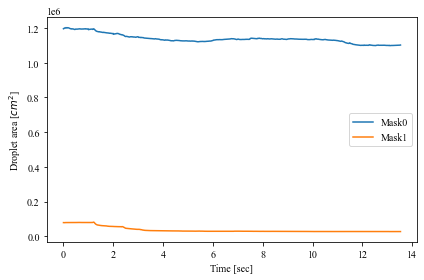

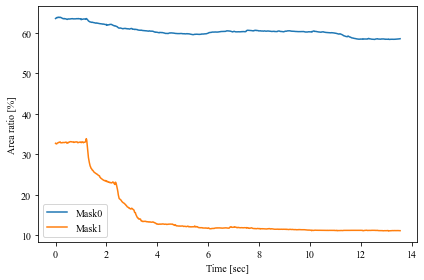

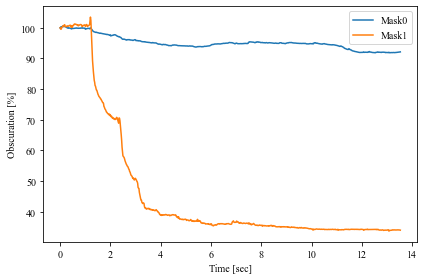

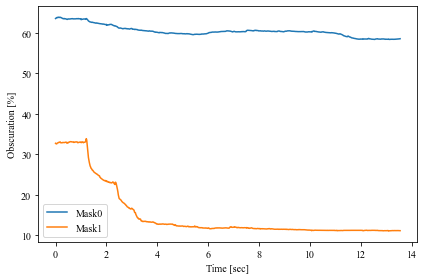

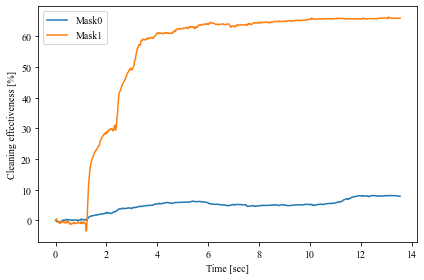

In [6]:
# Run cases 
ip['proc_dir'] = Path(r'C:\Users\anisu\OneDrive\Desktop\OLA')
ip['batch'] = 'y'

# Get file list
os.chdir(ip['proc_dir'])
if (ip['batch'] == 'y'):
    file_list = list_contents(ip['proc_dir'],'.mp4')
else:
    file_list = ['Water Droplets 60 Hz 80 Vrms.mp4']

# Loop over all files
for cnt,value in enumerate(file_list):
    
    os.chdir(ip['proc_dir'])
    ip['file_proc'] = value
    try:
        ip['current'] = float(value.split(' ')[-2])
        ip['voltage'] = float(value.split(' ')[-4])
    except:
        print('Invalid naming convention. Please end viedo name with x vrms y Amps.mp4')
    # Pre-process data file
    ip = preprocess_data(ip)
    
    # Call edge detection 
    data_out_edge = {}
    data_out_edge = edge_detection(ip)
    
    # Create plots
    print('Creating plots')
    data_out_edge = create_plots(data_out_edge,ip)
    
    # Write out data
    write_out_data(data_out_edge,ip)

    # Return to processing directory
    os.chdir(ip['proc_dir'])
    
print('Completed')

In [7]:
ip['bound_list']

[[[3, 7], [1915, 9], [1912, 996], [8, 994]],
 [[316, 306], [1569, 292], [1740, 473], [180, 465]]]